In [249]:
import os
import pandas as pd
import yaml
import csv

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
from scipy.stats import sem, t

sns.set_theme()

In [250]:
root_dir = r".\results\2024Apr23-175821_configs" # adam
# root_dir = r".\results\2024Apr19-212034_configs" # adam with mean
# root_dir = r".\results\2024Apr19-153358_configs" # sgd
# root_dir = r".\results\2024Apr19-182150_configs" # sgd with mean

In [251]:
def collect_experiment_data(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("loss_record.csv"):
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the loss record CSV file
                df = pd.read_csv(file_path)

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Add parameters as new columns to the DataFrame
                df["run_id"] = run_id
                df["tau"] = tau
                df["min_samples"] = min_samples

                # Append to the list of all data
                all_data.append(df)

    # Concatenate all data into a single DataFrame
    return pd.concat(all_data, ignore_index=True)


combined_data = collect_experiment_data(root_dir)
combined_data

aggregated_df = (
    combined_data.groupby(["run_id", "tau", "min_samples"])
    .agg({"epoch": "max"})
    .reset_index()
)

aggregated_df

,run_id,tau,min_samples,epoch
0,0,0.001,10,19
1,0,0.010,10,19
2,0,0.100,10,19
3,0,1.000,10,19
4,1,0.001,10,19
...,...,...,...,...
155,38,1.000,10,19
156,39,0.001,10,19
157,39,0.010,10,19
158,39,0.100,10,19


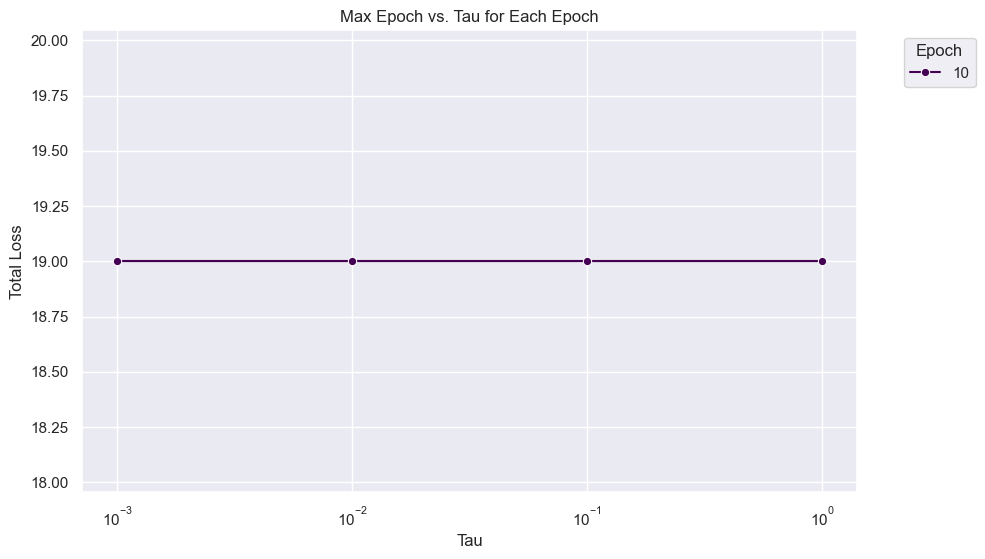

In [252]:
plt.figure(figsize=(10, 6))
# Assuming you want to plot the loss for the last epoch of each run, you can filter or aggregate the data as needed
sns.lineplot(
    data=aggregated_df,
    x="tau",
    y="epoch",
    hue="min_samples",
    palette="viridis",
    marker="o",
)
plt.xlabel("Tau")
plt.ylabel("Total Loss")
plt.xscale("log")
# plt.yscale('log')
plt.title("Max Epoch vs. Tau for Each Epoch")
plt.legend(title="Epoch", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [253]:
def collect_bellman_errors(root_dir):
    """
    Collects Bellman error values and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected Bellman errors and parameters.
    """
    all_errors = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file == "bellman_error.csv":
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the Bellman error values from the CSV file
                with open(file_path, "r") as error_file:
                    csv_reader = csv.reader(error_file)
                    headers = next(csv_reader)  # Skip header row
                    values = next(csv_reader)  # Get the values

                # Map the values to their corresponding headers
                bellman_errors = dict(zip(headers, values))
                validation_error = float(bellman_errors["validation_error"])
                training_error = float(bellman_errors["training_error"])

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Create a dictionary with the collected data
                error_data = {
                    "run_id": run_id,
                    "tau": tau,
                    "min_samples": min_samples,
                    "validation_error": validation_error,
                    "training_error": training_error,
                }

                # Append to the list of all errors
                all_errors.append(error_data)

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(all_errors)


# Example usage
bellman_errors_df = collect_bellman_errors(root_dir)
bellman_errors_df["validation_error"] = bellman_errors_df["validation_error"].fillna(
    10**32
)
bellman_errors_df["training_error"] = bellman_errors_df["training_error"].fillna(10**32)
bellman_errors_df

,run_id,tau,min_samples,validation_error,training_error
0,0,0.001,10,7.673396e-03,4.849571e-03
1,1,0.001,10,2.308467e-02,1.861390e-03
2,10,0.001,10,9.706663e-03,8.461291e-03
3,11,0.001,10,5.853918e+16,5.361773e+16
4,12,0.001,10,1.606825e-02,3.997071e-03
...,...,...,...,...,...
155,5,1.000,10,4.257481e-04,3.694748e-04
156,6,1.000,10,9.837718e-04,3.794874e-04
157,7,1.000,10,1.450766e-03,1.132865e-03
158,8,1.000,10,1.781771e-03,1.371583e-03


In [254]:
bellman_errors_df_melted = pd.melt(
    bellman_errors_df,
    id_vars=["run_id", "tau", "min_samples"],
    value_vars=["validation_error", "training_error"],
    var_name="error_type",
    value_name="error_value",
)
bellman_errors_df_melted

,run_id,tau,min_samples,error_type,error_value
0,0,0.001,10,validation_error,7.673396e-03
1,1,0.001,10,validation_error,2.308467e-02
2,10,0.001,10,validation_error,9.706663e-03
3,11,0.001,10,validation_error,5.853918e+16
4,12,0.001,10,validation_error,1.606825e-02
...,...,...,...,...,...
315,5,1.000,10,training_error,3.694748e-04
316,6,1.000,10,training_error,3.794874e-04
317,7,1.000,10,training_error,1.132865e-03
318,8,1.000,10,training_error,1.371583e-03


In [255]:
# # bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["tau"]!=0.01]
# bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["min_samples"] != 0]

In [256]:
# bellman_errors_df_filtered["min_samples"] = bellman_errors_df_filtered[
#     "min_samples"
# ].astype(str)

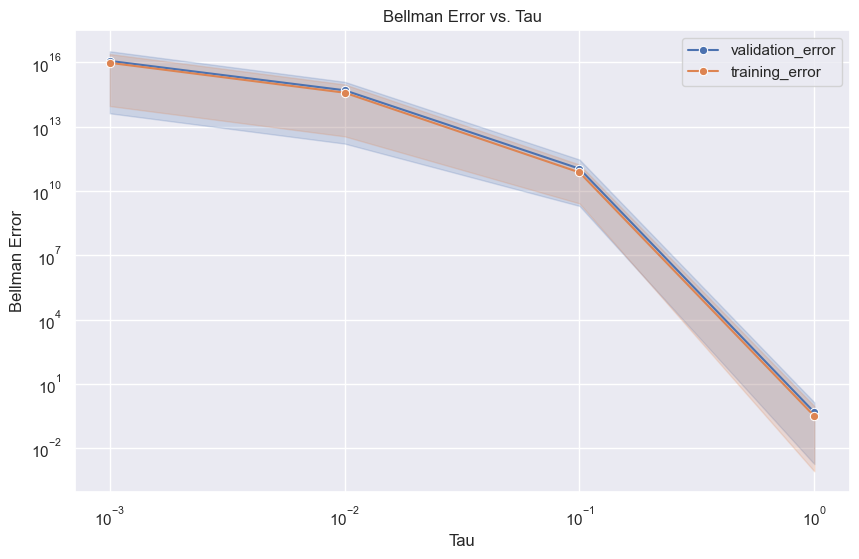

In [257]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bellman_errors_df_melted,
    x="tau",
    y="error_value",
    hue="error_type",
    marker="o",
    # errorbar=("pi", 100),
    errorbar="ci",
    # label="Bellman Error",
)
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()
plt.show()

In [258]:
baseline_dir = r".\results\2024Apr19-152635_baseline_configs" # adam
# baseline_dir = r".\results\2024Apr19-155944_baseline_configs"  # sgd

baseline_errors_df = collect_bellman_errors(baseline_dir)
baseline_errors_df

,run_id,tau,min_samples,validation_error,training_error
0,0,1,10,0.000472,0.000936
1,1,1,10,0.010711,0.000677
2,2,1,10,0.012616,0.003166
3,3,1,10,0.000217,0.006377
4,4,1,10,0.008198,0.001713
5,5,1,10,0.000450,0.001910
6,6,1,10,0.000706,0.000152
7,7,1,10,0.000376,0.003180
8,8,1,10,0.000686,0.000581
9,9,1,10,0.007241,0.004625


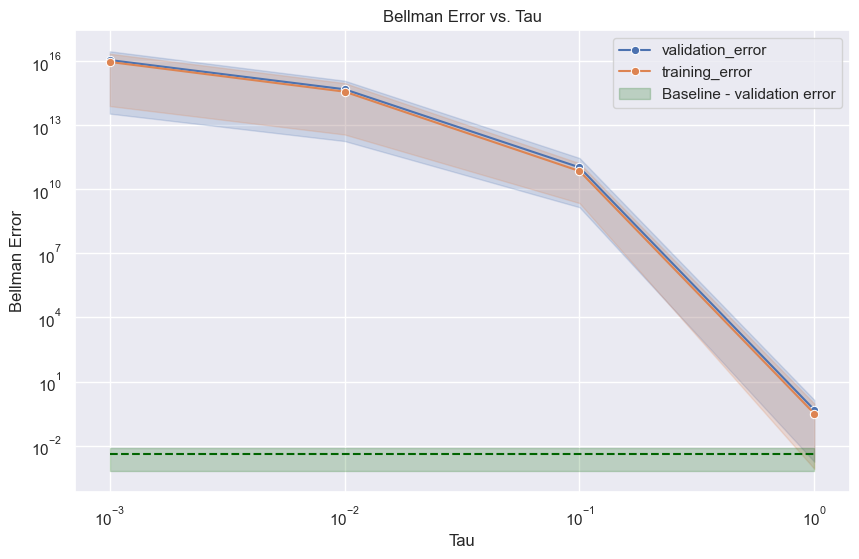

In [259]:
# Assuming baseline_errors_df is your dataframe
n = len(baseline_errors_df["validation_error"])  # Number of samples
baseline_avg_bellman_error = baseline_errors_df["validation_error"].mean()
baseline_std_dev = baseline_errors_df["validation_error"].std()
baseline_sem = sem(
    baseline_errors_df["validation_error"], nan_policy="omit"
)  # Calculate the SEM

# Confidence interval calculation (95% confidence)
t_critical = t.ppf(0.975, n - 1)  # Two-tailed t-value for 95% confidence
ci_range = t_critical * baseline_sem

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bellman_errors_df_melted,
    x="tau",
    y="error_value",
    hue="error_type",
    marker="o",
    errorbar="ci",  # This defaults to 95% CI
)

tau_min = bellman_errors_df["tau"].min()
tau_max = bellman_errors_df["tau"].max()

# Plot the mean line
plt.plot(
    [tau_min, tau_max],
    [baseline_avg_bellman_error, baseline_avg_bellman_error],
    linestyle="--",
    color="darkgreen",
)

# Plot the confidence interval around the mean
x_values = np.logspace(np.log10(tau_min), np.log10(tau_max), num=100)

plt.fill_between(
    x_values,
    [baseline_avg_bellman_error - ci_range] * len(x_values),
    [baseline_avg_bellman_error + ci_range] * len(x_values),
    color="darkgreen",
    alpha=0.2,
    label="Baseline - validation error",
)

plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()

plt.show()

In [260]:
print("Sample size (n):", n)
print("Standard Deviation:", baseline_std_dev)
if n > 1:
    baseline_sem = sem(
        baseline_errors_df["validation_error"], nan_policy="omit"
    )  # Adjust SEM calculation
    t_critical = t.ppf(0.975, n - 1)
    ci_range = t_critical * baseline_sem
    print("CI Range:", ci_range)
else:
    print("Not enough data to compute CI.")
print("CI Range:", ci_range)
print("Mean Error:", baseline_avg_bellman_error)
print("X Values Range:", x_values.min(), x_values.max())

Sample size (n): 10
Standard Deviation: 0.004960341290356965
CI Range: 0.003548414397938548
CI Range: 0.003548414397938548
Mean Error: 0.004167479250463657
X Values Range: 0.001 1.0


In [261]:
specific_tau = 1  # Set the specific tau value you are interested in
filtered_df = bellman_errors_df_melted[bellman_errors_df_melted["tau"] == specific_tau]

baseline_melted = pd.melt(
    baseline_errors_df,
    id_vars=["run_id", "tau", "min_samples"],
    value_vars=["validation_error", "training_error"],
    var_name="error_type",
    value_name="error_value",
)
baseline_melted["source"] = (
    "Baseline"  # Add a source column to indicate these are from baseline
)
# baseline_melted['error_type'] = baseline_melted['error_type'].replace({'validation_error': 'Validation', 'training_error': 'Training'})  # Rename for clarity

# Assuming df1 is your experimental data and already melted
filtered_df["source"] = "Tau = 1"  # Indicate these are experimental data

# Combine the two datasets
combined_df = pd.concat([filtered_df, baseline_melted], ignore_index=True)
combined_df

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_19720\3754585013.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["source"] = "Tau = 1"  # Indicate these are experimental data


,run_id,tau,min_samples,error_type,error_value,source
0,0,1.0,10,validation_error,17.163877,Tau = 1
1,1,1.0,10,validation_error,0.013179,Tau = 1
2,10,1.0,10,validation_error,0.000272,Tau = 1
3,11,1.0,10,validation_error,0.002445,Tau = 1
4,12,1.0,10,validation_error,0.001408,Tau = 1
...,...,...,...,...,...,...
95,5,1.0,10,training_error,0.001910,Baseline
96,6,1.0,10,training_error,0.000152,Baseline
97,7,1.0,10,training_error,0.003180,Baseline
98,8,1.0,10,training_error,0.000581,Baseline


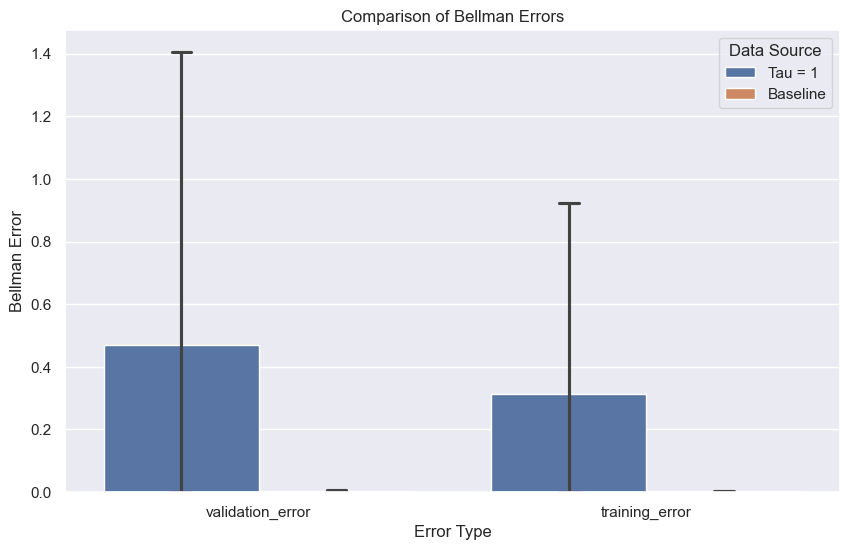

In [262]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=combined_df, x="error_type", y="error_value", hue="source", capsize=0.1
)

# Adding labels and titles
plt.xlabel("Error Type")
plt.ylabel("Bellman Error")
plt.title("Comparison of Bellman Errors")
plt.legend(title="Data Source")

plt.show()

In [263]:
# use mdp to generate transition distribution
# this generates another dataset of transitions

# then apply:
# ### Training
# input_size = len(states[0])  # Or another way to represent the size of your input
# output_size = len(actions)

# # Initialize the DQN
# dqn = DQN(input_size, output_size)

# loss_record = train_dqn(
#     dqn,
#     sampled_transitions_train,
#     Q_pi_random,
#     states,
#     actions,
#     gamma,
#     epsilon,
#     batch_size=batch_size,
#     max_iterations=train_max_iterations,
#     logger=logger,
# )

# bm_error = compute_bellmans_error(
#     dqn, validation_transitions=transitions_val, gamma=gamma
# )

### AND

# policy evaluation

# plot both

In [264]:
# do policy evaluation on train datasets -> Q
# Evaluate with Q on validation set

# training DQN == value iteration
# we want to do policy evaluation with DQN (we do this by changing the loss function with bellman equation for Q pi instead of Q*)
# if we want to do early stopping, do it with Q* instead of Q pi random